In [17]:
%matplotlib inline
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.ticker as ticker
from ..datasets import Dataset

ValueError: attempted relative import beyond top-level package

In [24]:
import sys, os
import pathlib
p=pathlib.Path.cwd().parents[0]
sys.path.append(str(p))

from datasets.utils import calc_pivots

In [2]:
five_min_data = pd.read_hdf('../data/processed/store.h5', key='cnn_data')
five_min_data.head()

,date,open,high,low,close,ema,sin_time,cos_time,btc,stc
0,2006-01-03 09:35:00-05:00,1259.00,1260.75,1259.00,1259.75,NaN,-0.625923,-0.779884,-104,96
1,2006-01-03 09:40:00-05:00,1259.50,1259.75,1258.50,1259.50,NaN,-0.642788,-0.766044,-104,96
2,2006-01-03 09:45:00-05:00,1259.25,1260.25,1259.25,1260.00,NaN,-0.659346,-0.751840,-104,96
3,2006-01-03 09:50:00-05:00,1259.75,1260.00,1258.50,1258.75,NaN,-0.675590,-0.737277,-104,96
4,2006-01-03 09:55:00-05:00,1259.00,1259.75,1257.50,1257.75,NaN,-0.691513,-0.722364,96,-104


In [3]:
%time
def calc_pivots(data):
    df = data.copy()
    df['ph'] = np.nan #pivot highs
    df['pl'] = np.nan #pivot lows
    df['swing'] = np.nan #swings
    
    #Initialize internal vars
    lower_low = higher_high = False
    pivot1_found = pivot1_was_low = False
    pivot1_index = pivot1_value = 0
    pivot2_found = pivot2_was_low = False
    pivot2_index = pivot2_value = 0

    for i in df.index[1:]:
        prev_low = df.at[i-1, 'low']
        curr_low = df.at[i, 'low']
        prev_high = df.at[i-1, 'high']
        curr_high = df.at[i, 'high']
        
        if lower_low:
            if curr_low > prev_low:
                df.at[i-1, 'pl'] = prev_low
                lower_low = False
        else:
            if curr_low < prev_low:
                lower_low = True
                
        if higher_high:
            if curr_high < prev_high:
                df.at[i-1, 'ph'] = prev_high
                higher_high = False
        else:
            if curr_high > prev_high:
                higher_high = True
                
        
        #This is the first pivot that we find
        if not pivot1_found:
            #pivot is a high
            if not np.isnan(df.at[i-1, 'ph']) and np.isnan(df.at[i-1, 'pl']):
                pivot1_was_low = False
                pivot1_index = i-1
                pivot1_found = True
                pivot1_value = df.at[i-1, 'ph']
                df.at[i-1, 'swing'] = df.at[i-1, 'ph']
            #pivot is a low
            elif not np.isnan(df.at[i-1, 'pl']) and np.isnan(df.at[i-1, 'ph']):
                pivot1_was_low = True
                pivot1_index = i-1
                pivot1_found = True
                pivot1_value = df.at[i-1, 'pl']
                df.at[i-1, 'swing'] = df.at[i-1, 'pl']
            elif not np.isnan(df.at[i-1, 'pl']) and not np.isnan(df.at[i-1, 'ph']):
                pass #unique case where bar is both pivot high and low
            
        elif pivot1_found and not pivot2_found:
            if not np.isnan(df.at[i-1, 'ph']) and np.isnan(df.at[i-1, 'pl']):
                if pivot1_was_low:
                    pivot2_was_low = False
                    pivot2_index = i-1
                    pivot2_found = True
                    pivot2_value = df.at[i-1, 'ph']
                    df.at[i-1, 'swing'] = df.at[i-1, 'ph']
                elif df.at[i-1, 'ph'] >= pivot1_value:
                    #update pivot1 if this is a higher high
                    df.at[pivot1_index, 'swing'] = np.nan
                    pivot1_index = i-1
                    pivot1_value = df.at[i-1, 'ph']
                    df.at[i-1, 'swing'] = df.at[i-1, 'ph']
            elif not np.isnan(df.at[i-1, 'pl']) and np.isnan(df.at[i-1, 'ph']):
                if not pivot1_was_low:
                    pivot2_was_low = True
                    pivot2_index = i-1
                    pivot2_found = True
                    pivot2_value = df.at[i-1, 'pl']
                    df.at[i-1, 'swing'] = df.at[i-1, 'pl']
                elif df.at[i-1, 'pl'] <= self.pivot1_value:
                    #update pivot1 if this is a lower low
                    df.at[pivot1_index, 'swing'] = np.nan
                    pivot1_index = i-1
                    pivot1_value = df.at[i-1, 'pl']
                    df.at[i-1, 'swing'] = df.at[i-1, 'pl']
            elif not np.isnan(df.at[i-1, 'pl']) and not np.isnan(df.at[i-1, 'ph']):
                #unique case where bar is both pivot high and low  
                pivot2_index = i-1
                pivot2_found = True
                if not pivot1_was_low: #Pivot 1 was high, so we make Pivot2 a low
                    pivot2_was_low = True
                    pivot2_value = df.at[i-1, 'pl']
                    df.at[i-1, 'swing'] = df.at[i-1, 'pl']
                else: #Pivot 1 was low, so we make Pivot2 a high
                    pivot2_was_low = False
                    pivot2_value = df.at[i-1, 'ph']
                    df.at[i-1, 'swing'] = df.at[i-1, 'ph']
                    
        elif pivot1_found and pivot2_found:
            if not np.isnan(df.at[i-1, 'ph']) and np.isnan(df.at[i-1, 'pl']):
                if pivot2_was_low: # 3 pivot sequence complete -- update p1 & p2 fields
                    pivot1_was_low = pivot2_was_low
                    pivot1_index = pivot2_index
                    pivot1_value = pivot2_value
                    pivot2_was_low = False
                    pivot2_index = i-1
                    pivot2_value = df.at[i-1, 'ph']
                    df.at[i-1, 'swing'] = df.at[i-1, 'ph']
                elif df.at[i-1, 'ph'] >= pivot2_value:
                    #update pivot2 if this is a higher high
                    df.at[pivot2_index, 'swing'] = np.nan
                    pivot2_index = i-1
                    pivot2_value = df.at[i-1, 'ph']
                    df.at[i-1, 'swing'] = df.at[i-1, 'ph']
            elif not np.isnan(df.at[i-1, 'pl']) and np.isnan(df.at[i-1, 'ph']):
                if not pivot2_was_low: #3 pivot seq complete
                    pivot1_was_low = pivot2_was_low
                    pivot1_index = pivot2_index
                    pivot1_value = pivot2_value
                    pivot2_was_low = True
                    pivot2_index = i-1
                    pivot2_value = df.at[i-1, 'pl']
                    df.at[i-1, 'swing'] = df.at[i-1, 'pl']
                elif df.at[i-1, 'pl'] <= pivot2_value:
                    #update pivot2 if this is a lower low
                    df.at[pivot2_index, 'swing'] = np.nan
                    pivot2_index = i-1
                    pivot2_value = df.at[i-1, 'pl']
                    df.at[i-1, 'swing'] = df.at[i-1, 'pl']
            elif not np.isnan(df.at[i-1, 'pl']) and not np.isnan(df.at[i-1, 'pl']):
                #unique case where bar is both pivot high and low      
                pivot1_was_low = pivot2_was_low
                pivot1_index = pivot2_index
                pivot1_value = pivot2_value
                pivot2_index = i-1
                
                if not pivot2_was_low: #2nd pivot was a high so 3rd pivot is a low
                    pivot2_was_low = True
                    pivot2_value = df.at[i-1, 'pl']
                    df.at[i-1, 'swing'] = df.at[i-1, 'pl']
                else:  # 2nd pivot was low so 3rd pivot is a high
                    pivot2_was_low = False
                    pivot2_value = df.at[i-1, 'ph']
                    df.at[i-1, 'swing'] = df.at[i-1, 'ph']
    
    return df
    
five_min_data = calc_pivots(five_min_data)
five_min_data.head()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.81 µs


,date,open,high,low,close,ema,sin_time,cos_time,btc,stc,ph,pl,swing
0,2006-01-03 09:35:00-05:00,1259.00,1260.75,1259.00,1259.75,NaN,-0.625923,-0.779884,-104,96,NaN,NaN,NaN
1,2006-01-03 09:40:00-05:00,1259.50,1259.75,1258.50,1259.50,NaN,-0.642788,-0.766044,-104,96,NaN,1258.5,1258.50
2,2006-01-03 09:45:00-05:00,1259.25,1260.25,1259.25,1260.00,NaN,-0.659346,-0.751840,-104,96,1260.25,NaN,1260.25
3,2006-01-03 09:50:00-05:00,1259.75,1260.00,1258.50,1258.75,NaN,-0.675590,-0.737277,-104,96,NaN,NaN,NaN
4,2006-01-03 09:55:00-05:00,1259.00,1259.75,1257.50,1257.75,NaN,-0.691513,-0.722364,96,-104,NaN,NaN,NaN


In [4]:
five_min_data.iloc[18096:18099]

,date,open,high,low,close,ema,sin_time,cos_time,btc,stc,ph,pl,swing
18096,2006-11-20 15:35:00-05:00,1403.00,1404.25,1402.75,1404.00,1403.887947,-0.779884,0.625923,96,-104,NaN,NaN,NaN
18097,2006-11-20 15:40:00-05:00,1404.00,1404.50,1403.50,1404.50,1403.946238,-0.766044,0.642788,0,0,NaN,NaN,NaN
18098,2006-11-20 15:45:00-05:00,1404.25,1404.50,1403.50,1403.75,1403.927548,-0.751840,0.659346,96,-104,1404.5,NaN,1404.5


In [5]:
def get_random_window(window_length, five_min_data):
    WINDOW = window_length
    random_start = np.random.randint(19, five_min_data.shape[0]-WINDOW)
    five_min_data['x'] = five_min_data.index
    data = five_min_data.iloc[random_start:random_start+WINDOW+1]
    return data

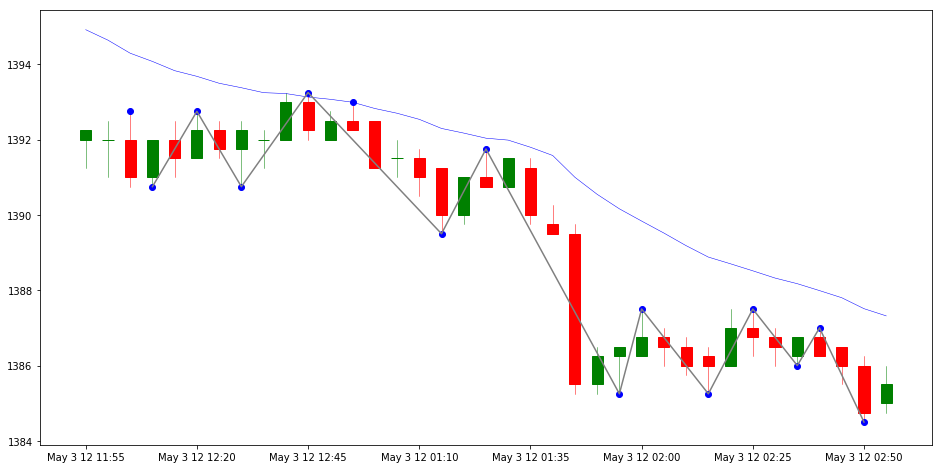

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
def format_hour(x, pos=None):
    thisind = np.clip(int(x + 0.5), 0, len(five_min_data.index) - 1)
    return five_min_data['date'][thisind].strftime('%b %-d %y %I:%M')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_hour))

data = get_random_window(36, five_min_data)
subset = data[['x','open','high','low','close']]
tuples = [tuple(x) for x in subset.values]
_ = candlestick_ohlc(ax, tuples, width=.5, colorup='g', colordown='r', alpha=1)
_ = ax.plot(data['x'].tolist(), data['ema'].tolist(), color='blue', lw=0.5) #plot ema

#Plot swing highs and lows
_ = ax.scatter(data[~data['ph'].isnull()]['x'].tolist(), 
               data[~data['ph'].isnull()]['ph'].tolist(),
               zorder=100, color='blue')
_ = ax.scatter(data[~data['pl'].isnull()]['x'].tolist(), 
               data[~data['pl'].isnull()]['pl'].tolist(),
               zorder=101, color='blue')
_ = ax.plot(data[~data['swing'].isnull()]['x'].tolist(), 
               data[~data['swing'].isnull()]['swing'].tolist(),
               zorder=102, color='gray', linestyle=None)

In [36]:
data.head()

,date,open,high,low,close,ema,sin_time,cos_time,sell_r,sell_b,buy_r,buy_b,x,ph,pl,swing
145472,2013-03-05 10:45:00-05:00,1538.75,1540.75,1538.75,1540.25,1534.034775,-0.831470,-0.555570,50,2,0,0,145472,NaN,NaN,NaN
145473,2013-03-05 10:50:00-05:00,1540.25,1541.25,1540.00,1541.00,1534.698129,-0.843391,-0.537300,0,0,0,0,145473,1541.25,NaN,1541.25
145474,2013-03-05 10:55:00-05:00,1541.00,1541.00,1540.00,1540.25,1535.226879,-0.854912,-0.518773,0,0,-50,1,145474,NaN,NaN,NaN
145475,2013-03-05 11:00:00-05:00,1540.25,1541.00,1539.25,1540.00,1535.681462,-0.866025,-0.500000,0,0,-50,0,145475,NaN,NaN,NaN
145476,2013-03-05 11:05:00-05:00,1539.75,1540.00,1538.25,1538.50,1535.949894,-0.876727,-0.480989,-50,1,0,0,145476,NaN,NaN,NaN


In [39]:
data[~data['ph'].isnull()]['x'].tolist()

[145473, 145478, 145481, 145488, 145496, 145500, 145504, 145506]